In [1]:
#import pandas as pd
#df = pd.io.stata.read_stata('/Users/elenaschigirev/Desktop/impic2016.dta')
#df.to_csv('/Users/elenaschigirev/Desktop/impic2016.csv')
#belgium = df[df['cntry'] == 'be']
#belgium

In [2]:
import pandas as pd
data_file = "/Users/elenaschigirev/Desktop/lw_project/project_setup/immigration.xlsx"
data = pd.read_excel(data_file,
                     sheet_name=0,
                     header=0,
                     index_col=False,
                     keep_default_na=True)
data.head()

,year,total_immigr,mb_immigr_total,mb_immigr_fem,mb_immigr_male,total_pop_be,fem_pop_be,male_pop_be,pop_change_be,Population ages 15-64 (% of total population) Belgium,...,"School enrollment, primary (% net) Belgium","School enrollment, primary (% net) Morocco","School enrollment, primary, female (% net) Belgium","School enrollment, primary, female (% net) Morocco","School enrollment, primary, male (% net) Belgium","School enrollment, primary, male (% net) Morocco",pol_change_minor,pol_change_mid,pol_change_major,visa_required
0,1977,55298,4313.0,2073.0,2240.0,9830358.0,5019097.0,4811261.0,9315,64.188460,...,96.29779,47.72865,96.42127,35.63422,96.18018,59.31814,0,0,0,0.0
1,1978,52594,3906.0,1900.0,2006.0,9839534.0,5025634.0,4813900.0,6923,64.523219,...,NaN,50.99459,NaN,38.23697,NaN,63.22642,0,1,0,0.0
2,1979,54854,5390.0,2273.0,3117.0,9848382.0,5032039.0,4816343.0,11502,64.932801,...,97.62043,53.43977,97.91599,40.36682,97.33893,65.97800,0,0,0,0.0
3,1980,54694,5001.0,2187.0,2814.0,9859243.0,5039073.0,4820170.0,10430,65.413216,...,98.15498,56.10223,98.44774,42.68273,97.87624,68.97377,0,0,0,0.0
4,1981,49298,3902.0,1691.0,2211.0,9858982.0,5042048.0,4816934.0,11519,65.870820,...,97.04024,58.79910,97.50450,45.23527,96.59838,71.80690,0,0,1,0.0


In [3]:
#data.info()

In [4]:
#data.isna().sum()

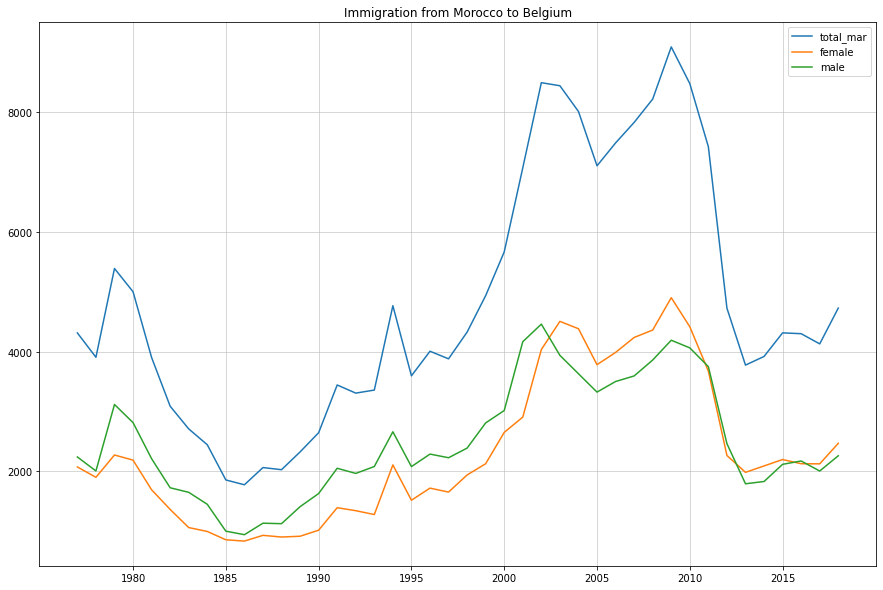

In [5]:
import matplotlib.pyplot as plt

year = data['year']
mb_immigr_total = data['mb_immigr_total']
mb_immigr_fem = data['mb_immigr_fem']
mb_immigr_male = data['mb_immigr_male']
total_immigr = data['total_immigr']

plt.figure(figsize=(15,10))
plt.plot(year, mb_immigr_total, label='total_mar')
plt.plot(year, mb_immigr_fem, label='female')
plt.plot(year, mb_immigr_male, label='male')
#plt.plot(year, total_immigr, label='total')
plt.legend()
plt.title('Immigration from Morocco to Belgium')
plt.grid(lw=0.5)
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.show()

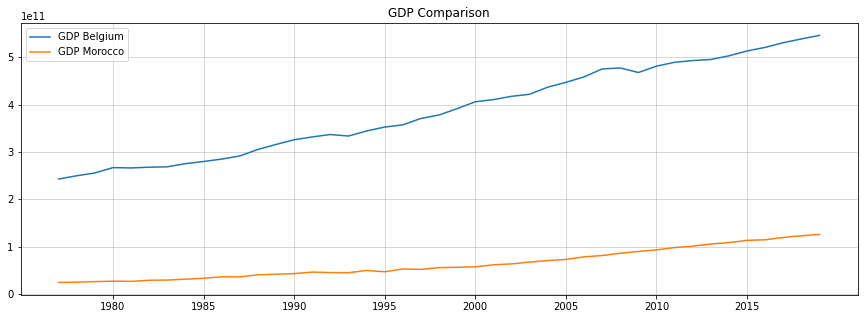

In [6]:
gdp_be = data['gdp_be']
gdp_mar = data['gdp_mar']

plt.figure(figsize=(15,5))
plt.plot(year, gdp_be, label='GDP Belgium')
plt.plot(year, gdp_mar, label='GDP Morocco')
plt.legend()
plt.title('GDP Comparison')
plt.grid(lw=0.5)
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.show()

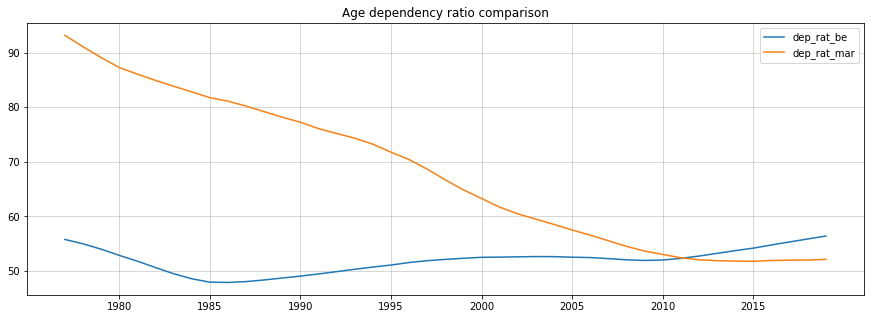

In [8]:
dep_rat_be = data['Age dependency ratio (% of working-age population) Belgium']
dep_rat_mar = data['Age dependency ratio (% of working-age population) Morocco']

plt.figure(figsize=(15,5))
plt.plot(year, dep_rat_be, label='dep_rat_be')
plt.plot(year, dep_rat_mar, label='dep_rat_mar')
plt.legend()
plt.title('Age dependency ratio comparison')
plt.grid(lw=0.5)
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.show()

[Text(0.5, 0, 'year'),
 Text(2.5, 0, 'mb_immigr_total'),
 Text(4.5, 0, 'mb_immigr_male'),
 Text(6.5, 0, 'fem_pop_be'),
 Text(8.5, 0, 'pop_change_be'),
 Text(10.5, 0, 'Population ages 15-64 (% of total population) Morocco'),
 Text(12.5, 0, 'Population growth (annual %) Morocco'),
 Text(14.5, 0, 'Life expectancy at birth, total (years) Morocco'),
 Text(16.5, 0, 'Age dependency ratio, old (% of working-age population) Belgium'),
 Text(18.5, 0, 'Age dependency ratio (% of working-age population) Morocco'),
 Text(20.5, 0, 'Age dependency ratio, young (% of working-age population) Morocco'),
 Text(22.5, 0, 'gdp_mar'),
 Text(24.5, 0, 'gdp_capita_mar'),
 Text(26.5, 0, 'Primary completion rate, female (% of relevant age group) Morocco'),
 Text(28.5, 0, 'Primary completion rate, total (% of relevant age group) Morocco'),
 Text(30.5, 0, 'Progression to secondary school, female (%) Morocco'),
 Text(32.5, 0, 'Refugee population by country or territory of asylum Belgium'),
 Text(34.5, 0, 'Rural popu

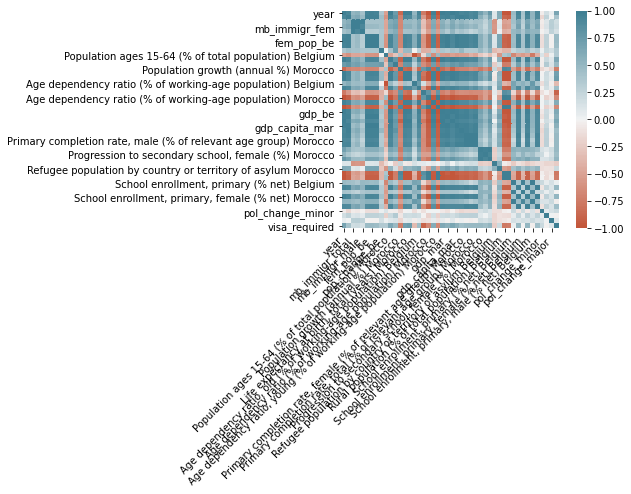

In [15]:
import seaborn as sns
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

/Users/elenaschigirev/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='gdp_be', ylabel='total_immigr'>

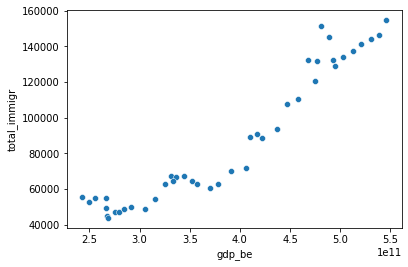

In [17]:
sns.scatterplot('gdp_be', 'total_immigr', data=data)

In [18]:
data.corr()

,year,total_immigr,mb_immigr_total,mb_immigr_fem,mb_immigr_male,total_pop_be,fem_pop_be,male_pop_be,pop_change_be,Population ages 15-64 (% of total population) Belgium,...,"School enrollment, primary (% net) Belgium","School enrollment, primary (% net) Morocco","School enrollment, primary, female (% net) Belgium","School enrollment, primary, female (% net) Morocco","School enrollment, primary, male (% net) Belgium","School enrollment, primary, male (% net) Morocco",pol_change_minor,pol_change_mid,pol_change_major,visa_required
year,1.000000,0.934795,0.511127,0.561723,0.426566,0.951084,0.954630,0.947474,0.367324,-0.512502,...,0.479004,0.947744,0.401127,0.959067,0.537185,0.903858,-0.032450,0.175382,0.043341,0.678621
total_immigr,0.934795,1.000000,0.579967,0.637096,0.484369,0.963540,0.964454,0.962446,0.454572,-0.608387,...,0.444333,0.929621,0.390984,0.933781,0.538626,0.894770,-0.172781,0.259295,0.001664,0.414613
mb_immigr_total,0.511127,0.579967,1.000000,0.985357,0.976919,0.415290,0.419712,0.410963,0.407306,-0.473829,...,0.434463,0.634386,0.321874,0.674072,0.483393,0.624500,-0.045735,0.112988,0.301839,0.182855
mb_immigr_fem,0.561723,0.637096,0.985357,1.000000,0.926192,0.477833,0.482274,0.473474,0.424479,-0.477498,...,0.371971,0.688556,0.275526,0.719699,0.450333,0.678358,-0.069366,0.138159,0.312872,0.203964
mb_immigr_male,0.426566,0.484369,0.976919,0.926192,1.000000,0.319730,0.323946,0.315623,0.368917,-0.449603,...,0.493824,0.540450,0.371928,0.589880,0.511435,0.531948,-0.014234,0.076773,0.275512,0.149268
total_pop_be,0.951084,0.963540,0.415290,0.477833,0.319730,1.000000,0.999878,0.999889,0.383030,-0.595210,...,0.471166,0.925676,0.418340,0.930275,0.565513,0.895887,-0.127354,0.267697,-0.017689,0.471252
fem_pop_be,0.954630,0.964454,0.419712,0.482274,0.323946,0.999878,1.000000,0.999535,0.386948,-0.587185,...,0.468026,0.929898,0.413959,0.934285,0.561453,0.900415,-0.124234,0.267766,-0.013564,0.480119
male_pop_be,0.947474,0.962446,0.410963,0.473474,0.315623,0.999889,0.999535,1.000000,0.379193,-0.602755,...,0.474089,0.921405,0.422467,0.926198,0.569304,0.891319,-0.130311,0.267570,-0.021633,0.462494
pop_change_be,0.367324,0.454572,0.407306,0.424479,0.368917,0.383030,0.386948,0.379193,1.000000,0.002399,...,0.243947,0.345592,0.329305,0.435864,0.278163,0.345167,0.025816,0.238356,0.160429,0.355342
Population ages 15-64 (% of total population) Belgium,-0.512502,-0.608387,-0.473829,-0.477498,-0.449603,-0.595210,-0.587185,-0.602755,0.002399,1.000000,...,-0.675083,-0.492804,-0.552485,-0.469577,-0.755019,-0.407518,0.117557,-0.204143,0.030437,0.343467


Feature selection